In [2]:
import numpy as np
import pandas as pd

import os
import glob

In [162]:
# %matplotlib qt5
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# import bioscrape as bs

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica Neue'], 
                 'serif': ['Helvetica Neue']})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

## Generate plots of gating effects

In [4]:
test = pd.read_csv('../../Local Data/20181009 top 4 A B cell vars A=B flow samples/23hr/C4.csv')
test.columns

Index(['HDR-T', 'FSC-A', 'SSC-A', 'CFP/VioBlue-A', 'PE-A', 'mKate/APC-A',
       'GFP/FITC-A', 'AH_perc_gate', 'mKate/APC-A_GMMgate'],
      dtype='object')

C:\Users\geeze\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\geeze\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\geeze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


C:\Users\geeze\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


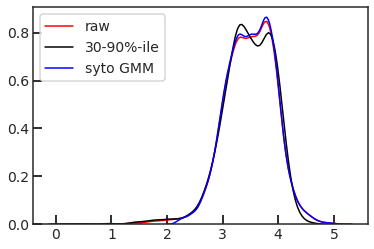

In [5]:
sns.kdeplot(test.loc[:, 'mKate/APC-A'].apply(np.log10))
sns.kdeplot(test.loc[test['AH_perc_gate'] == 1, 'mKate/APC-A'].apply(np.log10))
sns.kdeplot(test.loc[test['mKate/APC-A_GMMgate'] == 1, 'mKate/APC-A'].apply(np.log10))

plt.legend(labels=['raw', '30-90%-ile', 'syto GMM'])

### This is a work in progress, wanted to check first to see what we got and then move forward with analysis

## Plot fractions on and off in YFP channel over time

In [119]:
first = [i+j for i in ['A', 'B', 'C'] for j in ['1','2','3', '4', '5', '6', '7', '8', '9']]
second = [i+j for i in ['D', 'E', 'F', 'G', 'H'] for j in ['1','2','3', '4', '5', '6', '7', '8']]

#these are the only ones that all 4 tpts have in common due to incomplete 0hr sampling
wells_10 = first + second


#all 96 wells (common for 7, 19, 23 time points)
wells = [i+j for i in ['A','B','C','D','E','F','G','H'] for j in ['1','2','3','4','5','6','7','8','9','10','11','12']]

In [120]:
tpts = [0, 7, 19, 23]
t_last3 = [7, 19, 23]

In [121]:
gates = ['mKate/APC-A_GMMgate', 'AH_perc_gate']

In [122]:
def get_ratios (timepoints, well, gate):
    
    ratios = []
    for tpt in timepoints:
        ana = pd.read_csv('../../Local Data/20181009 top 4 A B cell vars A=B flow samples/' + str(tpt) + 'hr/' + str(tpt) + 'hr_yfp_GMManalysis.csv')

        one = ana['well'] == well

        two = ana['gate'] == gate

        info = ana.loc[one & two, :]

        #OFF cells are A (BFP+), ON cells are B(YFP+). This division is A:B ratio
        ratio = info['fraction OFF'] / info['fraction ON']

        ratios.append(ratio.values[0])

    rs = pd.Series(data=ratios, index=timepoints, name=well)
    
    return rs

In [123]:
all_ratios = pd.DataFrame([get_ratios(tpts, w, gates[0]) for w in wells_10]).T

In [124]:
all_ratios = all_ratios.reset_index().rename(columns={'index' : 'Time (hr)'})

In [125]:
all_ratios = pd.melt(all_ratios, id_vars='Time (hr)', var_name='well', value_name='A:B ratio')

In [126]:
all_ratios.head()

,Time (hr),well,A:B ratio
0,0,A1,20.027778
1,7,A1,0.122121
2,19,A1,0.000000
3,23,A1,0.163052
4,0,A2,9.255864


C:\Users\geeze\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


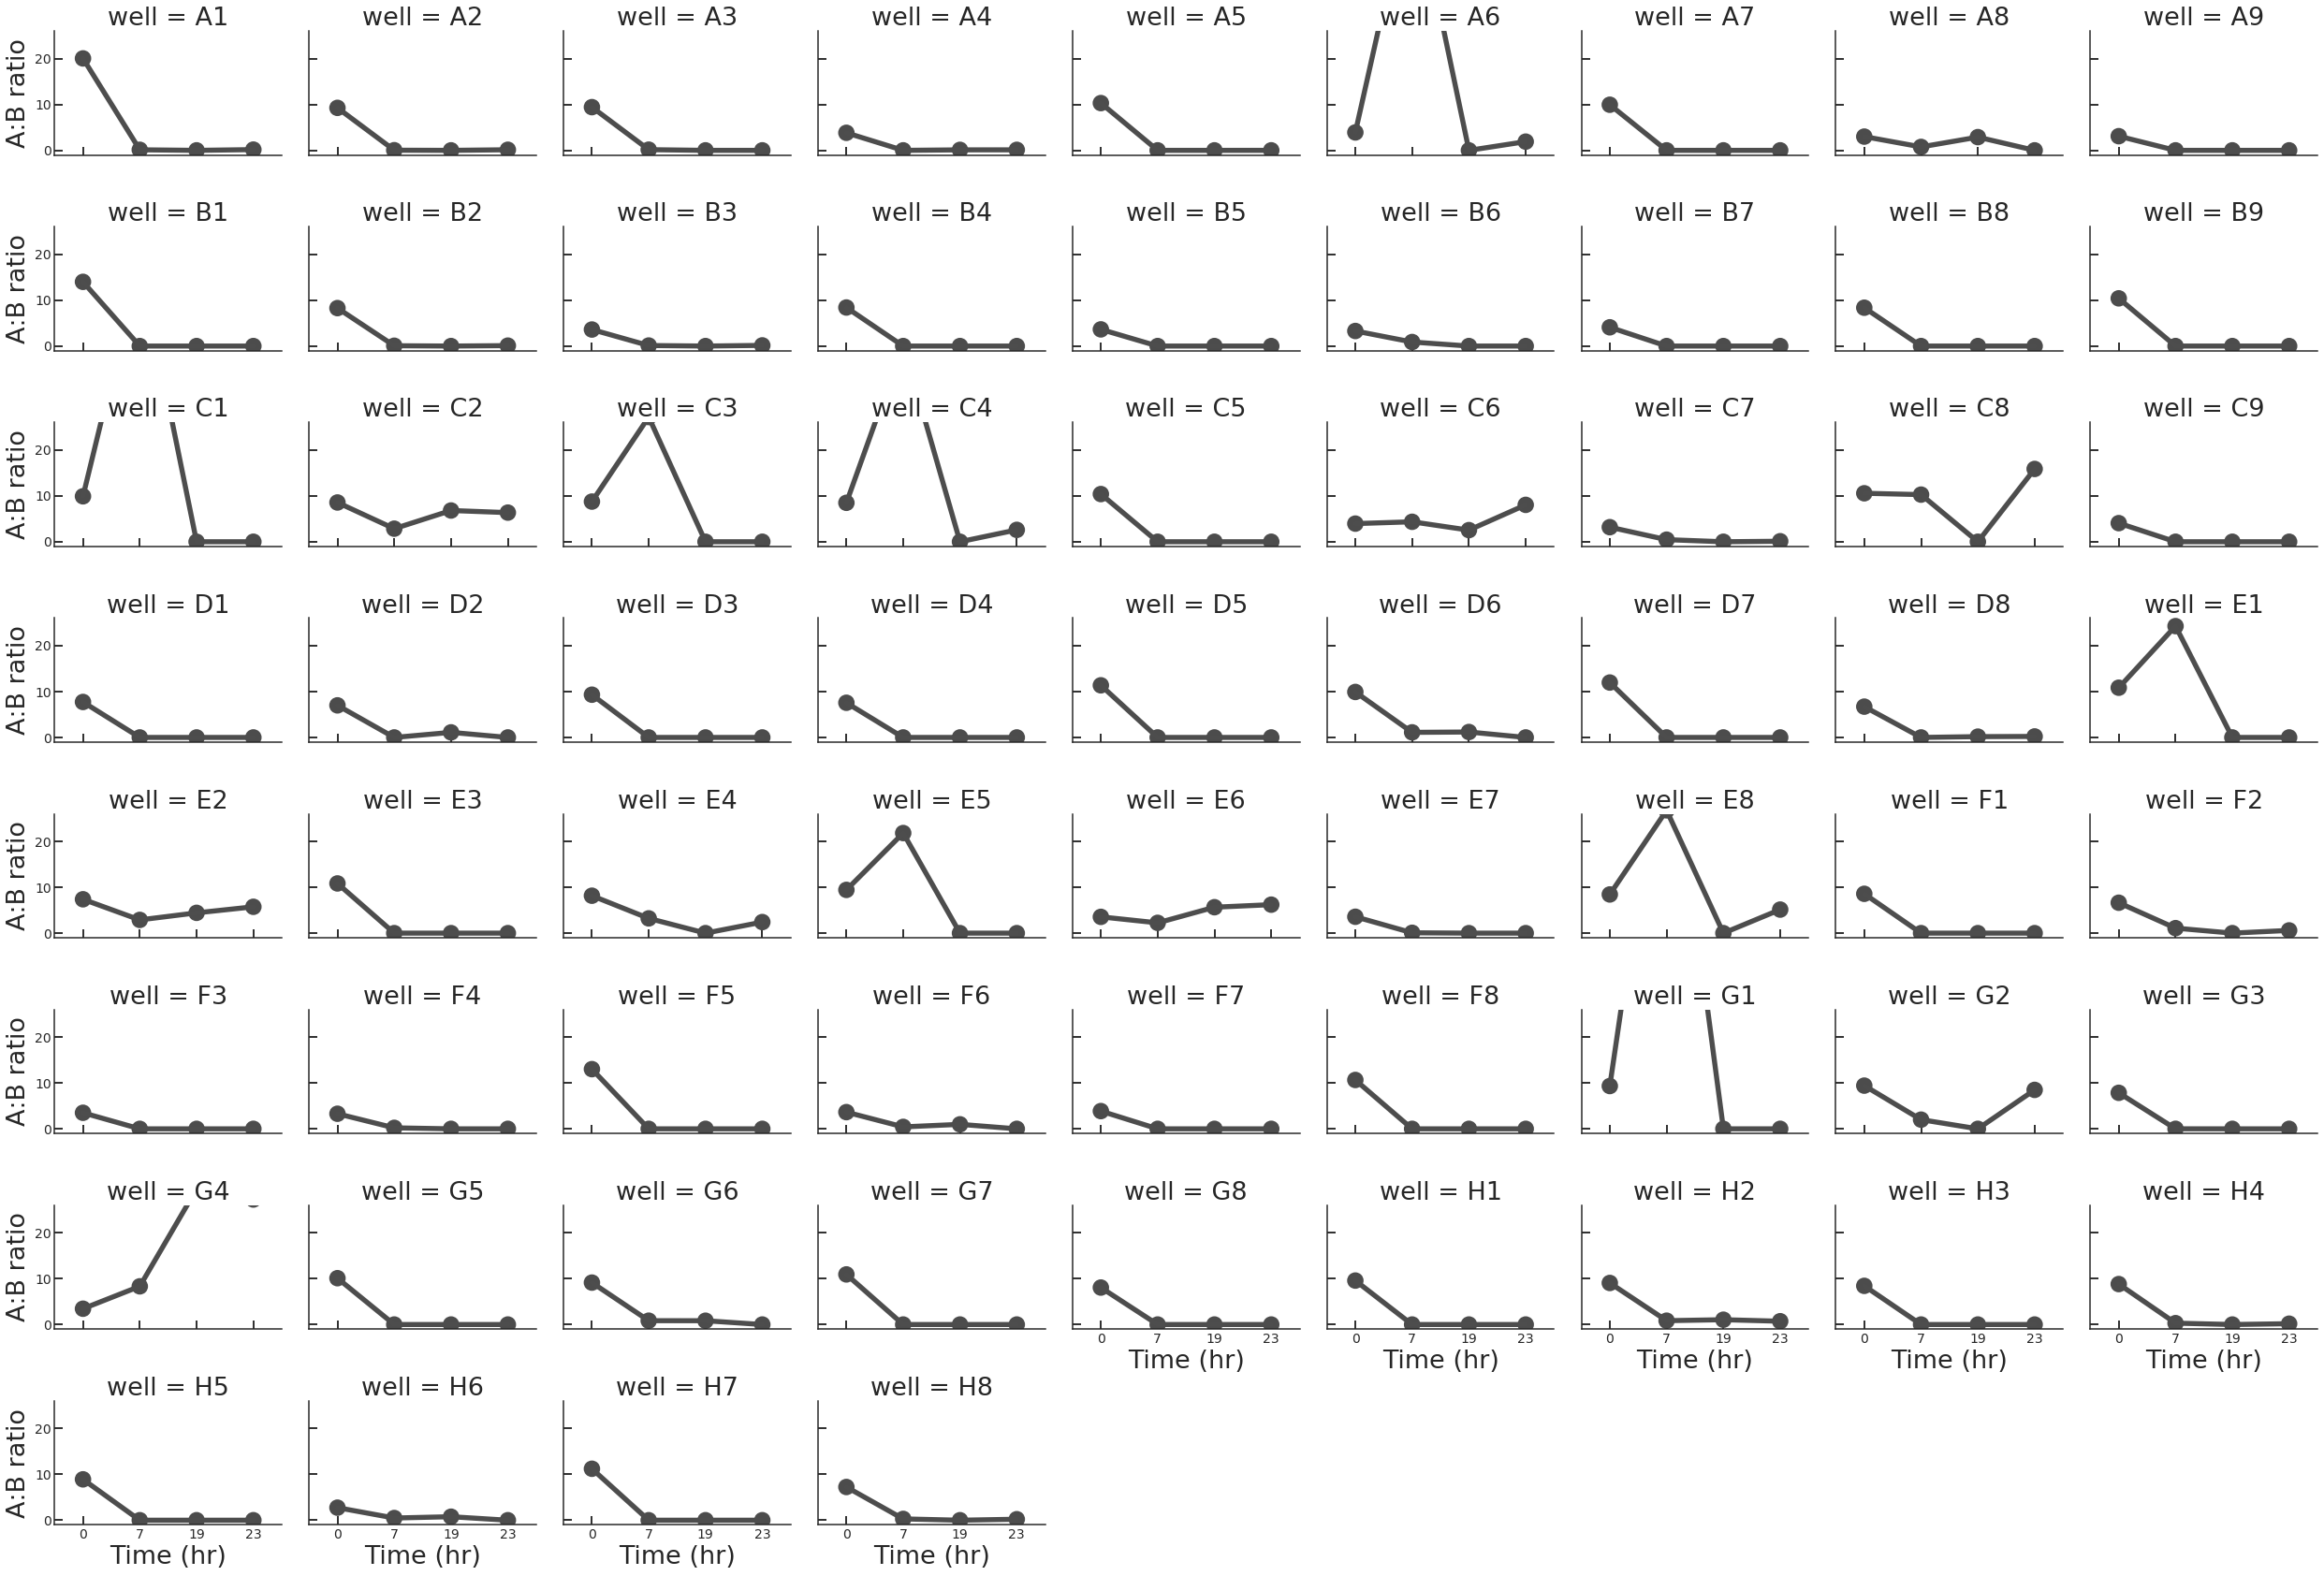

In [164]:
g = sns.FacetGrid(all_ratios, col="well", col_wrap=9, height=3, aspect=1.3, ylim=(-1,26), margin_titles=True)
g.map(sns.pointplot, "Time (hr)", "A:B ratio", color=".3", ci=None, scale=2);

In [165]:
g.set_titles("")

In [166]:
g.fig.savefig('../../Local Data/20181009 top 4 A B cell vars A=B flow samples/all_ratios_time.pdf')